In [1]:
import numpy as np
import matplotlib.pyplot as plt

import experiment

In [2]:
N, M = 1000, 1000 # размерность экспериментов

exps = []

**Введение**
В экспериментах f и h -- кв. формы, а G -- билинейная форма.

Седловая задача имеет вид $F(x) = \min_x \left( f(x) + \max_y \left( G(x, y) - h(y) \right) \right)$

$g(x) = \max_y \left( G(x, y) - h(y) \right)$

Для генерации кв. форм с заданными $L$ и $\mu$ используется генерация случайных собственных значений $\lambda_1, \ldots, \lambda_n$ из отрезка $[\mu, L]$ и умножения $A^T \cdot diag(\lambda_1, \ldots, \lambda_n) \cdot A$, где $A$ --- случайная ортонормированная матрица.

G --- билинейная форма ($G(x,y) = \langle x, Ay\rangle$, где для матрицы $A$ значения выбраны из распределения $U(-1, 1)$).

In [3]:
exp0, _, _, _ = experiment.generateQuadraticFormExperiment(
        N, M,
        {'L': 4, 'mu': 2},
        {'min': -1/4, 'max': 1/4},
        {'L': 6, 'mu': 3},
        1111
    )
exps.append(exp0)
exp0.constants()

{'L_f': 4.000000000000015,
 'L_G': 9.087142443747151,
 'L_h': 6.00000000000005,
 'mu_x': 1.999999999999981,
 'mu_y': 2.9999999999999902}

In [4]:
exp1, _, _, _ = experiment.generateQuadraticFormExperiment(
        N, M,
        {'L': 8, 'mu': 4},
        {'min': -1/4, 'max': 1/4},
        {'L': 12, 'mu': 6},
        1111
    )
exps.append(exp1)
exp1.constants()

{'L_f': 8.000000000000034,
 'L_G': 9.087142443747151,
 'L_h': 12.000000000000103,
 'mu_x': 4.000000000000006,
 'mu_y': 5.9999999999999885}

In [5]:
exp2, _, _, _ = experiment.generateQuadraticFormExperiment(
        N, M,
        {'L': 20, 'mu': 2},
        {'min': -1/4, 'max': 1/4},
        {'L': 10, 'mu': 9},
        1111
    )
exps.append(exp2)
exp2.constants()

{'L_f': 19.999999999999975,
 'L_G': 9.087142443747151,
 'L_h': 10.000000000000071,
 'mu_x': 2.000000000000004,
 'mu_y': 9.000000000000112}

In [6]:
exp3, _, _, _ = experiment.generateQuadraticFormExperiment(
        N, M,
        {'L': 10, 'mu': 9},
        {'min': -1/4, 'max': 1/4},
        {'L': 20, 'mu': 2},
        1111
    )
exps.append(exp3)
exp3.constants()

{'L_f': 9.999999999999972,
 'L_G': 9.087142443747151,
 'L_h': 19.999999999999932,
 'mu_x': 9.000000000000087,
 'mu_y': 2.000000000000015}

_

In [7]:
np.random.seed(100)

x_0 = np.random.random(N)
y_0 = np.random.random(M)

In [8]:
np.sum(x_0**2),np.sum(y_0**2)

(330.67905945640393, 311.9972004784303)

**Решение седловой задачи**

Решение седловой задачи.
out --- алгоритм по $x$, in --- алгоритм по $y$.

Во внутренней задаче (поиск $y$ для нахождения градиента $g(x)$) для начального значения используется $y$ с предыдущей задачи. Она также решается при помощи ускоренного метаалгоритма.

В качестве внутреннего алгоритма используется покомпонентный метод Нестерова.

В x_grad_stop_eps и y_grad_stop_eps есть возможность задать остановку по норме градиента вместо числа шагов.

In [9]:
def RunSaddle(x_0, y_0, exp, k_out=50, k_in=50, k_n=5, x_grad_stop_eps=None, y_grad_stop_eps=None):
    c = exp.constants()
    
    stop_callback_for_y = None
    if y_grad_stop_eps is not None:
        stop_callback_for_y = lambda grad: np.sum(grad**2) < y_grad_stop_eps**2
        
    stop_callback_for_x = None
    if x_grad_stop_eps is not None:
        stop_callback_for_x = lambda grad: np.sum(grad**2) < x_grad_stop_eps**2
    
    x, y, stats = experiment.runSaddleExperiment(exp, {
        'x_0': x_0,
        'y_0': y_0,
        'out': {
            'H': c['L_f'] * 2,
            'K': k_out,
            'stop_callback': stop_callback_for_x
        },
        'out_nesterov': {
            'K': k_n,
            'Li': np.array([(c['L_h'] + 2 * (c['L_G']**2) / c['mu_y'])] * N),
            'S': np.array([((c['L_h'] + 2 * (c['L_G']**2) / c['mu_y']) + 1)**(1/2)] * N),
            'stop_callback': None
        },
        'in': {
            'H': c['L_h'] * 2,
            'K': k_in,
            'stop_callback': stop_callback_for_y
        },
        'in_nesterov': {
            'K': k_n,
            'Li': np.array([c['L_G']] * M),
            'S': np.array([(c['L_G'] + 1)**(1/2)] * M),
            'stop_callback': None
        }
    })
    
    return x, y, stats


**Решение седловой задачи с увеличивающейся точностью решения по $y$.**

out --- алгоритм по $x$, in --- алгоритм по $y$.

Идея заключается в том, что на первых итерациях не тратить много шагов на нахождение точного $y$ (решение внутренней задачи),
но при этом постепенно увеличивать точность, чтобы в конце решать задачу для $y$ достаточно точно.

In [10]:
def RunSaddleAdaptiveEps(x_0, y_0, exp, k_out=50, k_in=50, k_n=5, eps_start=10**-4, eps_alpha=0.9998):
    c = exp.constants()

    class CallbackForY:
        def __init__(self, eps_start_, eps_alpha_):
            self.eps = eps_start_
            self.alpha = eps_alpha
            
        def __call__(self, grad):
            self.eps *= self.alpha
            return np.sum(grad**2) < self.eps**2
    
    x, y, stats = experiment.runSaddleExperiment(exp, {
        'x_0': x_0,
        'y_0': y_0,
        'out': {
            'H': c['L_f'] * 2,
            'K': k_out,
            'stop_callback': None
        },
        'out_nesterov': {
            'K': k_n,
            'Li': np.array([(c['L_h'] + 2 * (c['L_G']**2) / c['mu_y'])] * N),
            'S': np.array([((c['L_h'] + 2 * (c['L_G']**2) / c['mu_y']) + 1)**(1/2)] * N),
            'stop_callback': None
        },
        'in': {
            'H': c['L_h'] * 2,
            'K': k_in,
            'stop_callback': CallbackForY(eps_start, eps_alpha)
        },
        'in_nesterov': {
            'K': k_n,
            'Li': np.array([c['L_G']] * M),
            'S': np.array([(c['L_G'] + 1)**(1/2)] * M),
            'stop_callback': None
        }
    })
    
    return x, y, stats


**Каталист**

Обычное решение дополнительно обернуто в еще один УМ с $f = 0$ и $g = F$.

In [11]:
def RunSaddleCatalist(x_0, y_0, exp, k_catalist, mu_mult, k_out=50, k_in=50, k_n=5, x_grad_stop_eps=None, y_grad_stop_eps=None):
    c = exp.constants()
    
    stop_callback_for_y = None
    if y_grad_stop_eps is not None:
        stop_callback_for_y = lambda grad: np.sum(grad**2) < y_grad_stop_eps**2
        
    stop_callback_for_x = None
    if x_grad_stop_eps is not None:
        stop_callback_for_x = lambda grad: np.sum(grad**2) < x_grad_stop_eps**2

    x, y, stats = experiment.runSaddleCatalistExperiment(exp, {
        'x_0': x_0,
        'y_0': y_0,
        'catalist': {
            'H': c['mu_x'] * mu_mult,
            'K': k_catalist,
            'stop_callback': None
        },
        'out': {
            'H': c['L_f'] * 2,
            'K': k_out,
            'stop_callback': stop_callback_for_x
        },
        'out_nesterov': {
            'K': k_n,
            'Li': np.array([(c['L_h'] + 2 * (c['L_G']**2) / c['mu_y'])] * N),
            'S': np.array([((c['L_h'] + 2 * (c['L_G']**2) / c['mu_y']) + 1)**(1/2)] * N),
            'stop_callback': None
        },
        'in': {
            'H': c['L_h'] * 2,
            'K': k_in,
            'stop_callback': stop_callback_for_y
        },
        'in_nesterov': {
            'K': k_n,
            'Li': np.array([c['L_G']] * M),
            'S': np.array([(c['L_G'] + 1)**(1/2)] * M),
            'stop_callback': None
        }
    })
    
    return x, y, stats


In [12]:
calc_res = lambda exp, x, y: exp.f.func(x) + exp.G.func(x, y) - exp.h.func(y)
calc_grad_x = lambda exp, x, y: np.sqrt(np.sum((exp.f.grad(x) + exp.G.grad_x(x, y))**2))
calc_grad_y = lambda exp, x, y: np.sqrt(np.sum((exp.G.grad_y(x, y) - exp.h.grad(y))**2))

In [13]:
res_simple_40 = []
res_simple_10 = []
#res_simple_5 = []
res_simple_eps = []
res_catalist_20 = []
res_catalist_10 = []
res_catalist_eps = []

In [14]:
res_simple_40 = []
res_simple_10 = []
#res_simple_5 = []
res_catalist_20 = []
res_catalist_10 = []
for i, exp in enumerate(exps):
    print('Эксперимент {}. params={}'.format(i, exp.constants()))
    
    %time x, y, stat = RunSaddle(x_0, y_0, exp, 100, 40, 5)
    print('Simple (100, 40): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_simple_40.append(stat)
    
    %time x, y, stat = RunSaddle(x_0, y_0, exp, 400, 10, 5)
    print('Simple (400, 10): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_simple_10.append(stat)
    
    #%time x, y, stat = RunSaddle(x_0, y_0, exp, 600, 7, 5)
    #print('Simple (800, 5): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    #res_simple_5.append(stat)
    
    %time x, y, stat = RunSaddleCatalist(x_0, y_0, exp, 20, 5, 20, 10, 5)
    print('Catalist (20, 20, 10): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_catalist_20.append(stat)
    
    %time x, y, stat = RunSaddleCatalist(x_0, y_0, exp, 40, 5, 10, 10, 5)
    print('Catalist (40, 10, 10): f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_catalist_10.append(stat)
    
    print()

Эксперимент 0. params={'L_f': 4.000000000000015, 'L_G': 9.087142443747151, 'L_h': 6.00000000000005, 'mu_x': 1.999999999999981, 'mu_y': 2.9999999999999902}
CPU times: user 2min 30s, sys: 632 ms, total: 2min 30s
Wall time: 1min 15s
Simple (100, 40): f(x, y)=0.009136047322932607
||f'_x(x_0, y_0)||=92.50490385592535 ||f'_x(x, y)||=0.3613672923389668
||f'_y(x_0, y_0)||=117.82802895932362 ||f'_y(x, y)||=1.2175771632882364e-05
CPU times: user 2min 32s, sys: 560 ms, total: 2min 33s
Wall time: 1min 16s
Simple (400, 10): f(x, y)=0.00013711883839424139
||f'_x(x_0, y_0)||=92.50490385592535 ||f'_x(x, y)||=0.044099330738131916
||f'_y(x_0, y_0)||=117.82802895932362 ||f'_y(x, y)||=3.1470023477058235e-06
CPU times: user 2min 31s, sys: 736 ms, total: 2min 32s
Wall time: 1min 16s
Catalist (20, 20, 10): f(x, y)=0.008110132233018146
||f'_x(x_0, y_0)||=92.50490385592535 ||f'_x(x, y)||=0.36705574500190374
||f'_y(x_0, y_0)||=117.82802895932362 ||f'_y(x, y)||=7.330628688172121e-05
CPU times: user 2min 31s, sys

In [15]:
res_simple_eps = []
for i, exp in enumerate(exps):
    print('Experiment {}. params={}'.format(i, exp.constants()))
    
    %time x, y, stat = RunSaddle(x_0, y_0, exp, 400, 20, 5, None, 1e-4)
    print('Simple EPS=1e-4: f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_simple_eps.append(stat)

Experiment 0. params={'L_f': 4.000000000000015, 'L_G': 9.087142443747151, 'L_h': 6.00000000000005, 'mu_x': 1.999999999999981, 'mu_y': 2.9999999999999902}
CPU times: user 2min 35s, sys: 752 ms, total: 2min 36s
Wall time: 1min 18s
Simple EPS=1e-4: f(x, y)=0.00013829729621813353
||f'_x(x_0, y_0)||=92.50490385592535 ||f'_x(x, y)||=0.044354942532955056
||f'_y(x_0, y_0)||=117.82802895932362 ||f'_y(x, y)||=8.296391344727894e-05
Experiment 1. params={'L_f': 8.000000000000034, 'L_G': 9.087142443747151, 'L_h': 12.000000000000103, 'mu_x': 4.000000000000006, 'mu_y': 5.9999999999999885}
CPU times: user 2min 59s, sys: 784 ms, total: 3min
Wall time: 1min 30s
Simple EPS=1e-4: f(x, y)=0.0002573861643240795
||f'_x(x_0, y_0)||=130.6187930232335 ||f'_x(x, y)||=0.06411318618929525
||f'_y(x_0, y_0)||=183.82156385181213 ||f'_y(x, y)||=7.565197424238529e-05
Experiment 2. params={'L_f': 19.999999999999975, 'L_G': 9.087142443747151, 'L_h': 10.000000000000071, 'mu_x': 2.000000000000004, 'mu_y': 9.000000000000112

In [16]:
res_simple_adaptive_eps = []
res_simple_adaptive_eps_fast = []

for i, exp in enumerate(exps):
    print('Эксперимент {}. params={}'.format(i, exp.constants()))
    
    %time x, y, stat = RunSaddleAdaptiveEps(x_0, y_0, exp, 400, 20, 5, 1e-2, 0.9998)
    print('Simple Adaptive EPS=1e-2 alpha=0.9998: f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    res_simple_adaptive_eps.append(stat)
    
    #%time x, y, stat = RunSaddleAdaptiveEps(x_0, y_0, exp, 400, 20, 5, 1e-3, 0.9995)
    #print('Simple Adaptive EPS=1e-3 alpha=0.9999: f(x, y)={}\n||f\'_x(x_0, y_0)||={} ||f\'_x(x, y)||={}\n||f\'_y(x_0, y_0)||={} ||f\'_y(x, y)||={}'.format(calc_res(exp, x, y), calc_grad_x(exp, x_0, y_0), calc_grad_x(exp, x, y), calc_grad_y(exp, x_0, y_0), calc_grad_y(exp, x, y)))
    #res_simple_adaptive_eps_fast.append(stat)
    
    print()

Эксперимент 0. params={'L_f': 4.000000000000015, 'L_G': 9.087142443747151, 'L_h': 6.00000000000005, 'mu_x': 1.999999999999981, 'mu_y': 2.9999999999999902}
CPU times: user 1min 23s, sys: 356 ms, total: 1min 24s
Wall time: 42.2 s
Simple Adaptive EPS=1e-2 alpha=0.9998: f(x, y)=0.0013602206992833117
||f'_x(x_0, y_0)||=92.50490385592535 ||f'_x(x, y)||=0.21509438418535687
||f'_y(x_0, y_0)||=117.82802895932362 ||f'_y(x, y)||=0.0005313753736731051

Эксперимент 1. params={'L_f': 8.000000000000034, 'L_G': 9.087142443747151, 'L_h': 12.000000000000103, 'mu_x': 4.000000000000006, 'mu_y': 5.9999999999999885}
CPU times: user 1min 22s, sys: 416 ms, total: 1min 23s
Wall time: 41.7 s
Simple Adaptive EPS=1e-2 alpha=0.9998: f(x, y)=0.0005186878688674254
||f'_x(x_0, y_0)||=130.6187930232335 ||f'_x(x, y)||=0.10177645243622102
||f'_y(x_0, y_0)||=183.82156385181213 ||f'_y(x, y)||=0.0006918059748793901

Эксперимент 2. params={'L_f': 19.999999999999975, 'L_G': 9.087142443747151, 'L_h': 10.000000000000071, 'mu_x

**Зависимость найденного значения от кол-ва вызовов оракулов $\nabla f$ и $\nabla h$**

In [17]:
def collectFfromfOracleSimple(stats):
    return stats['out_stats']['fs']

def collectFfromhOracleSimple(stats):
    r = []
    for st in stats['in_stats']:
        r += st['fs']
    return r

def collectGradNormfromfOracleSimple(stats):
    return stats['out_stats']['gs']

def collectGradNormfromhOracleSimple(stats):
    r = []
    for st in stats['in_stats']:
        r += st['gs']
    return r

def collectFfromfOracleCatalist(stats):
    r = []
    for st in stats['saddle']:
        r += collectFfromfOracleSimple(st)
    return r

def collectFfromhOracleCatalist(stats):
    r = []
    for st in stats['saddle']:
        r += collectFfromhOracleSimple(st)
    return r

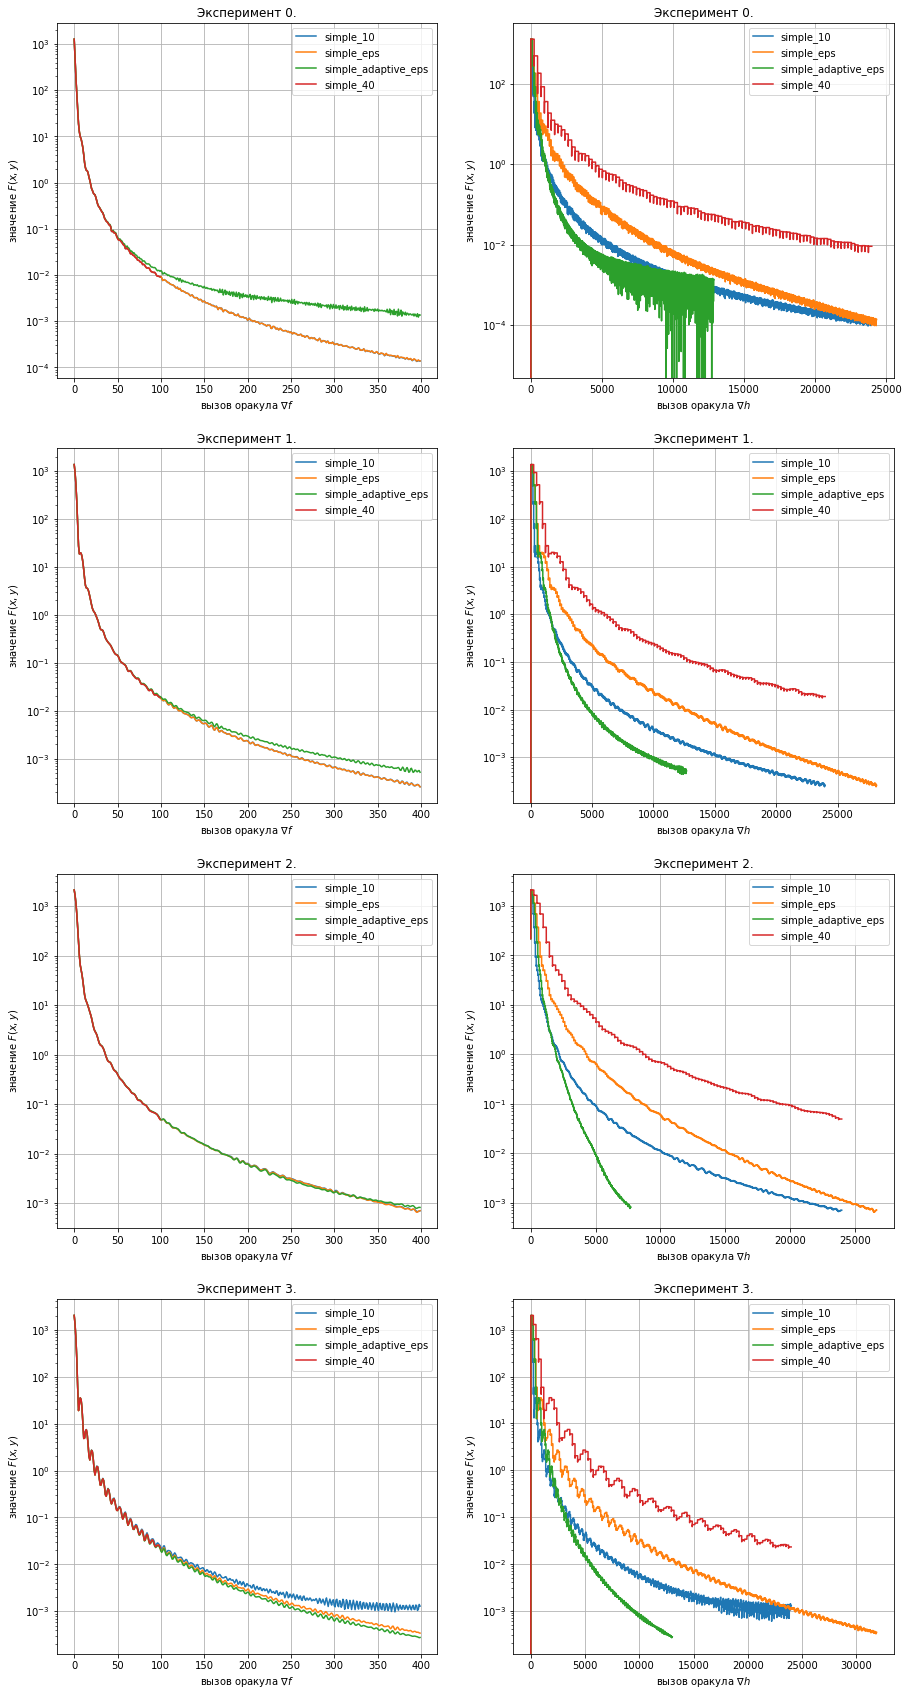

In [18]:
plt.figure(figsize=(15,30))

for i in range(len(exps)):
    ax = plt.subplot(4, 2, 1 + i * 2)
    ax.set_title('Эксперимент {}.'.format(i))
    
    Ff = collectFfromfOracleSimple(res_simple_10[i])
    ax.plot(range(len(Ff)), Ff, label='simple_10')
    
    Ff = collectFfromfOracleSimple(res_simple_eps[i])
    ax.plot(range(len(Ff)), Ff, label='simple_eps')
    
    Ff = collectFfromfOracleSimple(res_simple_adaptive_eps[i])
    ax.plot(range(len(Ff)), Ff, label='simple_adaptive_eps')
    
    Ff = collectFfromfOracleSimple(res_simple_40[i])
    ax.plot(range(len(Ff)), Ff, label='simple_40')
       
    plt.yscale("log")
    plt.ylabel('значение $F(x, y)$')
    plt.xlabel('вызов оракула $\\nabla f$')
    plt.grid(True)
    plt.legend()
    
    
    ax = plt.subplot(4, 2, 1 + i * 2 + 1)
    ax.set_title('Эксперимент {}.'.format(i))

    Fh = collectFfromhOracleSimple(res_simple_10[i])
    ax.plot(range(len(Fh)), Fh, label='simple_10')
    
    Fh = collectFfromhOracleSimple(res_simple_eps[i])
    ax.plot(range(len(Fh)), Fh, label='simple_eps')
    
    Fh = collectFfromhOracleSimple(res_simple_adaptive_eps[i])
    ax.plot(range(len(Fh)), Fh, label='simple_adaptive_eps')
    
    Fh = collectFfromhOracleSimple(res_simple_40[i])
    ax.plot(range(len(Fh)), Fh, label='simple_40')
    
    plt.yscale("log")
    plt.ylabel('значение $F(x, y)$')
    plt.xlabel('вызов оракула $\\nabla h$')
    plt.grid(True)
    plt.legend()
    
    

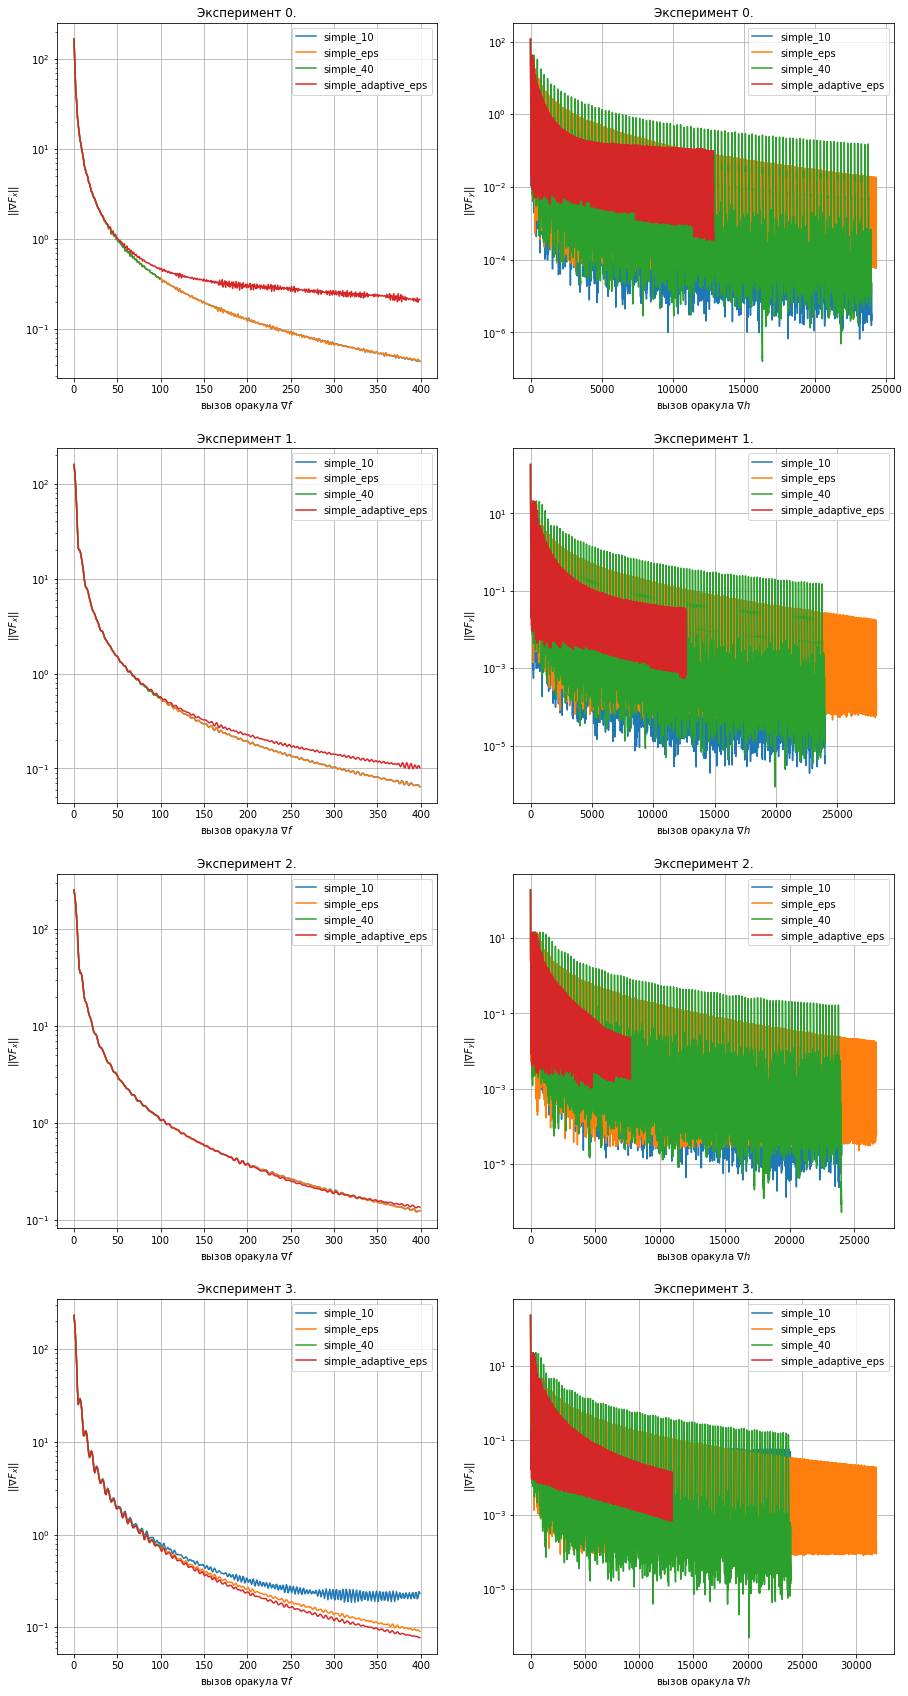

In [19]:
plt.figure(figsize=(15,30))

for i in range(len(exps)):
    ax = plt.subplot(4, 2, 1 + i * 2 + 0)
    ax.set_title('Эксперимент {}.'.format(i))

    Gf = collectGradNormfromfOracleSimple(res_simple_10[i])
    ax.plot(range(len(Gf)), Gf, label='simple_10')
    
    Gf = collectGradNormfromfOracleSimple(res_simple_eps[i])
    ax.plot(range(len(Gf)), Gf, label='simple_eps')
    
    
    Gf = collectGradNormfromfOracleSimple(res_simple_40[i])
    ax.plot(range(len(Gf)), Gf, label='simple_40')
    
    Gf = collectGradNormfromfOracleSimple(res_simple_adaptive_eps[i])
    ax.plot(range(len(Gf)), Gf, label='simple_adaptive_eps')
    
    #Fh = collectFfromhOracleSimple(res_simple_adaptive_eps_fast[i])
    #ax.plot(range(len(Fh)), Fh, label='simple_adaptive_eps_fast')
    
    plt.yscale("log")
    plt.ylabel('$||\\nabla F_x||$')
    plt.xlabel('вызов оракула $\\nabla f$')
    plt.grid(True)
    plt.legend()
    
    
    ax = plt.subplot(4, 2, 1 + i * 2 + 1)
    ax.set_title('Эксперимент {}.'.format(i))

    Gh = collectGradNormfromhOracleSimple(res_simple_10[i])
    ax.plot(range(len(Gh)), Gh, label='simple_10')
    
    Gh = collectGradNormfromhOracleSimple(res_simple_eps[i])
    ax.plot(range(len(Gh)), Gh, label='simple_eps')
    
    Gh = collectGradNormfromhOracleSimple(res_simple_40[i])
    ax.plot(range(len(Gh)), Gh, label='simple_40')
    
    Gh = collectGradNormfromhOracleSimple(res_simple_adaptive_eps[i])
    ax.plot(range(len(Gh)), Gh, label='simple_adaptive_eps')
    
    #Fh = collectFfromhOracleSimple(res_simple_adaptive_eps_fast[i])
    #ax.plot(range(len(Fh)), Fh, label='simple_adaptive_eps_fast')
    
    plt.yscale("log")
    plt.ylabel('$||\\nabla F_y||$')
    plt.xlabel('вызов оракула $\\nabla h$')
    plt.grid(True)
    plt.legend()
    

**Выводы**

simple_* имеют фиксированное число итераций для обоих метаалгоритмов, число означает кол-во итераций поиска по $y$ для одной итерации поиска по $x$.
simple_eps имеет проверку на норму градиента для остановки.
simple_adaptive_eps --- решают внутреннюю задачу с увеличивающейся точностью.

В данном случае алгоритмы с фиксированным числом итераций почти везде сходятся одинакого, кроме последнего эксперимента (большая $L_h$, маленькая $\mu_y$), где simple_10 не получает достаточную точность решения по $y$, из-за чего по $x$ тоже сходится хуже.

Для алгоритма с адаптивной точностью видно, что он по вызовам $\nabla f$ сходится в последних двух экспериментах не сильно хуже других алгоритмов, однако делает значительно меньше вызовов $\nabla h$. Это также видно ни на гистограммах ниже.

На графиках по $\nabla h$ есть вертикальные линии (на самом деле они не вертикальные, а так кажется из-за того, что они занимают мало итераций, при том, что на графике итераций десятки тысяч), которые возникают из-за того, что после сдвига по $x$ надо перерешивать задачу по $y$, поскольку он теперь не максимизирует функцию. Чем больше сдвиг по $x$ влияет на функцию, тем больше эти линии.

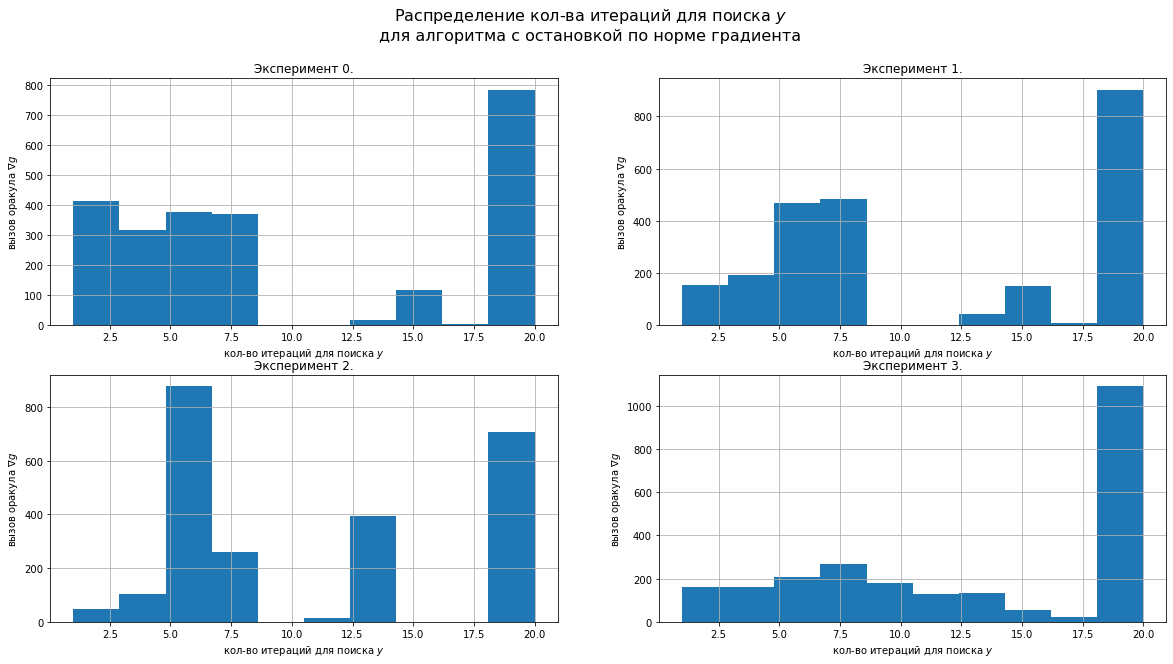

In [20]:
def collectItersBygOracleSimple(stats):
    r = []
    for st in stats['in_stats']:
        r.append(st['iters'])
    return r


f = plt.figure(figsize=(20,10))
f.suptitle('Распределение кол-ва итераций для поиска $y$\nдля алгоритма с остановкой по норме градиента', fontsize=16)

for i in range(len(exps)):
    ax = plt.subplot(2, 2, 1 + i)
    ax.set_title('Эксперимент {}.'.format(i))
    
    ItersByg = collectItersBygOracleSimple(res_simple_eps[i])
    
    #ax.plot(range(len(ItersByg)), ItersByg)
    ax.hist(ItersByg)
    
    plt.ylabel('вызов оракула $\\nabla g$')
    plt.xlabel('кол-во итераций для поиска $y$')
    plt.grid(True)
    #plt.legend()


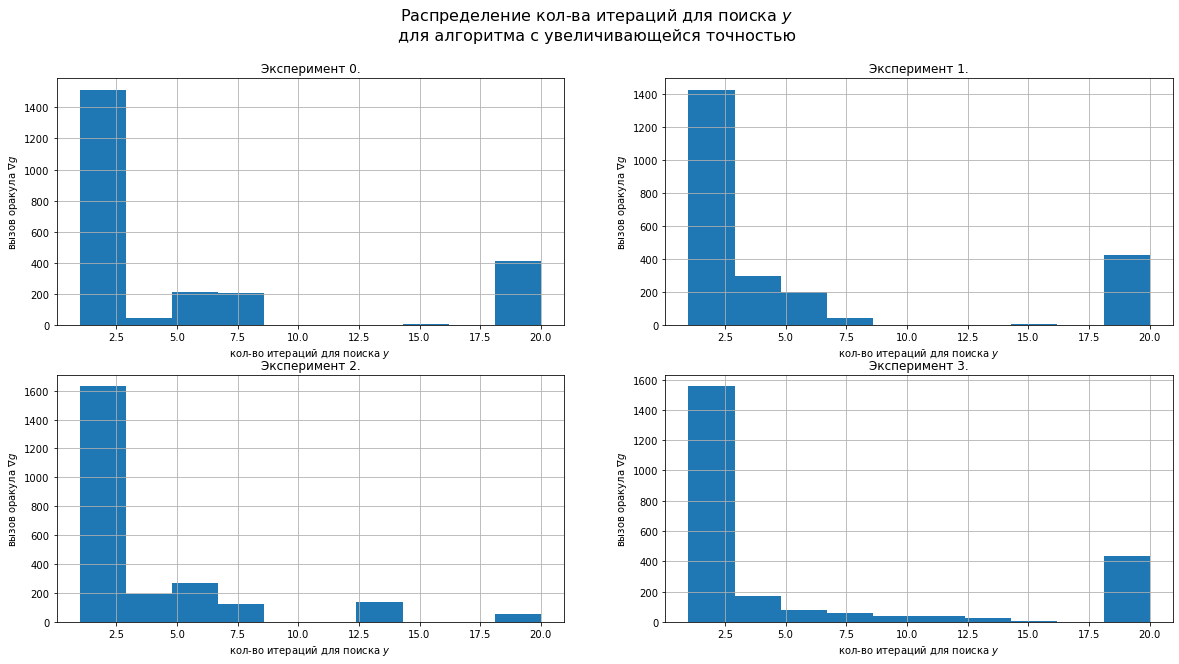

In [21]:
def collectItersBygOracleSimple(stats):
    r = []
    for st in stats['in_stats']:
        r.append(st['iters'])
    return r


f = plt.figure(figsize=(20,10))
f.suptitle('Распределение кол-ва итераций для поиска $y$\nдля алгоритма с увеличивающейся точностью', fontsize=16)
for i in range(len(exps)):
    ax = plt.subplot(2, 2, 1 + i)
    ax.set_title('Эксперимент {}.'.format(i))
    
    ItersByg = collectItersBygOracleSimple(res_simple_adaptive_eps[i])
    
    #ax.plot(range(len(ItersByg)), ItersByg)
    ax.hist(ItersByg)
    
    plt.ylabel('вызов оракула $\\nabla g$')
    plt.xlabel('кол-во итераций для поиска $y$')
    plt.grid(True)
    #plt.legend()

**Вывод**
Как видно при использовании остановки по $\varepsilon$ часто делается мало итераций, однако в большинстве случаев делаются все доступные итерации, т.е. заметного выигрыша по количеству итераций по сравнению с другими методами не получается.

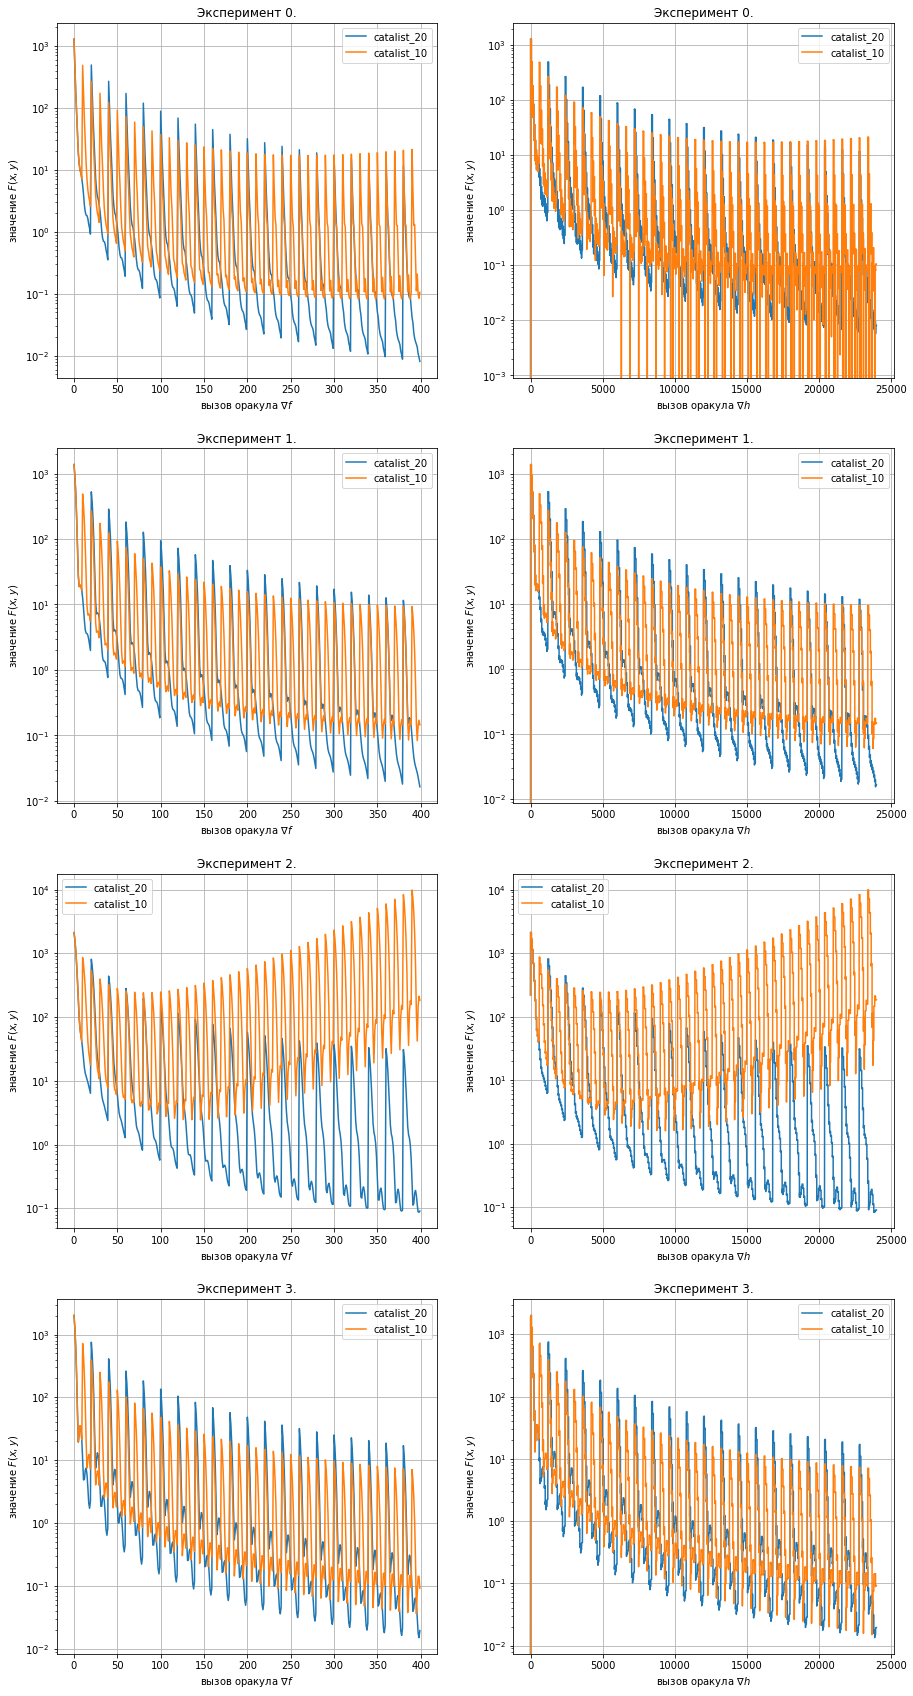

In [22]:
plt.figure(figsize=(15,30))

for i in range(len(exps)):
    ax = plt.subplot(4, 2, 1 + i * 2)
    ax.set_title('Эксперимент {}.'.format(i))

    Ff = collectFfromfOracleCatalist(res_catalist_20[i])
    ax.plot(range(len(Ff)), Ff, label='catalist_20')
    
    Ff = collectFfromfOracleCatalist(res_catalist_10[i])
    ax.plot(range(len(Ff)), Ff, label='catalist_10')
    
    #Ff = collectFfromfOracleCatalist(res_catalist_eps[i])
    #ax.plot(range(len(Ff)), Ff, label='catalist_eps')
        
    plt.yscale("log")
    plt.ylabel('значение $F(x, y)$')
    plt.xlabel('вызов оракула $\\nabla f$')
    plt.grid(True)
    plt.legend()
    
    
    ax = plt.subplot(4, 2, 1 + i * 2 + 1)
    ax.set_title('Эксперимент {}.'.format(i))
    
    Fh = collectFfromhOracleCatalist(res_catalist_20[i])
    ax.plot(range(len(Fh)), Fh, label='catalist_20')
    
    Fh = collectFfromhOracleCatalist(res_catalist_10[i])
    ax.plot(range(len(Fh)), Fh, label='catalist_10')
    
    #Fh = collectFfromhOracleCatalist(res_catalist_eps[i])
    #ax.plot(range(len(Fh)), Fh, label='catalist_eps')
    
    plt.yscale("log")
    plt.ylabel('значение $F(x, y)$')
    plt.xlabel('вызов оракула $\\nabla h$')
    plt.grid(True)
    plt.legend()
    

**Выводы**

catalist_* имеет фиксированное число итераций для обоих метаалгоритмов.
catalist_eps имеет проверку на норму градиента.


Видно, что каталист в данном случае тоже сходится плохо из-за того, что на каждой итерации из-за шага во внешнем цикле (по x) его отбрасывает в большие значений функции.
В эксперименте 2 из-за малого числа итераций в алгоритме, решающем седловую задачу, ведущему к плохой точности решения, каталист расходится.
